In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import OrderedDict
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('crest')
pd.set_option('display.max_columns', None)

In [ ]:
df = pd.read_csv('/content/df_union sep.csv')

In [ ]:
print("Dimensiones del dataset:", df.shape)
print("\nPrimeras filas:")
display(df.head())

Dimensiones del dataset: (127730, 17)

Primeras filas:


,hash_sha256_num,Género,Grupo etario,Código de la entidad,Nombre de la entidad,Régimen,Tipo de afiliado,Estado del afiliado,Condición del beneficiario,Zona de Afiliación,Departamento,Municipio,Nivel del Sisbén,Grupo poblacional del afiliado,Cantidad de registros,Fecha de actualización,id_fecha
0,5204768788666620970620740779577990891400309118...,Femenino,1 a 5,EPS037,NUEVA EPS S.A.,Contributivo,BENEFICIARIO,Activo,NO APLICA,Urbana,ANTIOQUIA,BETULIA,N,VÍCTIMAS DEL CONFLICTO ARMADO INTERNO,2.0,2025-09-06 22:28:56,5204768788666620970620740779577990891400309118...
1,3209477146886072244375401426617199273647468673...,Masculino,15 a 19,EPS041,NUEVA EPS S.A. -CM,Contributivo,COTIZANTE,Activo,NO APLICA,Urbana,HUILA,PITALITO,1,POBLACIÓN CON SISBEN,2.0,2025-09-06 22:28:56,3209477146886072244375401426617199273647468673...
2,1507202225368402031044662422082201657205588484...,Femenino,15 a 19,EPS041,NUEVA EPS S.A. -CM,Contributivo,BENEFICIARIO,Activo,NO APLICA,Urbana,BOYACA,SOGAMOSO,0,NaN,13.0,2025-09-06 22:28:56,1507202225368402031044662422082201657205588484...
3,1004051050503216142304294800692106401215686040...,Femenino,50 a 55,EPS037,NUEVA EPS S.A.,Contributivo,COTIZANTE,Activo,NO APLICA,Urbana,CORDOBA,LA APARTADA,0,NaN,3.0,2025-09-06 22:28:56,1004051050503216142304294800692106401215686040...
4,1097372498284927802666695841961888946324313955...,Femenino,60 a 65,EPS037,NUEVA EPS S.A.,Contributivo,COTIZANTE,Activo,NO APLICA,Urbana,CUNDINAMARCA,ARBELAEZ,1,POBLACIÓN CON SISBEN,1.0,2025-09-06 22:28:56,1097372498284927802666695841961888946324313955...


In [ ]:
# ============================================
# 2) Nombres de columnas y tipos
#    (puedes ajustar si tu archivo difiere)
# ============================================
# Intento robusto de encontrar columnas por nombre aproximado
def find_col(cands):
    cols_lower = {c.lower(): c for c in df.columns}
    for pat in cands:
        for cl in cols_lower:
            if pat in cl:
                return cols_lower[cl]
    return None

col_hash          = find_col(["hash_sha256", "hash"])
col_genero        = find_col(["género", "genero"])
col_grupo_etario  = find_col(["grupo etario", "grupo_etario"])
col_codigo_eps    = find_col(["código de la entidad", "codigo de la entidad", "codigo_entidad"])
col_nombre_eps    = find_col(["nombre de la entidad", "nombre_entidad"])
col_regimen       = find_col(["régimen", "regimen"])
col_tipo_af       = find_col(["tipo de afiliado", "tipo_afiliado"])
col_estado_af     = find_col(["estado del afiliado", "estado_afiliado"])
col_cond_ben      = find_col(["condición del beneficiario", "condicion del beneficiario", "condicion_beneficiario"])
col_zona          = find_col(["zona de afiliación", "zona de afiliacion", "zona"])
col_depto         = find_col(["departamento"])
col_mpio          = find_col(["municipio"])
col_nivel_sisben  = find_col(["nivel del sisbén", "nivel del sisben", "sisben"])
col_grupo_pob     = find_col(["grupo poblacional del afiliado", "grupo poblacional"])
col_cant_reg      = find_col(["cantidad de registros", "cantidad_registros", "n_reg"])
col_fecha_act     = find_col(["fecha de actualización", "fecha_actualizacion", "fecha act"])

# Identificadores y listas por tipo
cat_cols = [c for c in [
    col_genero, col_grupo_etario, col_codigo_eps, col_nombre_eps, col_regimen,
    col_tipo_af, col_estado_af, col_cond_ben, col_zona, col_depto, col_mpio,
    col_nivel_sisben, col_grupo_pob
] if c is not None]

num_cols = [c for c in [col_cant_reg] if c is not None]
date_cols = [c for c in [col_fecha_act] if c is not None]

print("\nCategóricas:", cat_cols)
print("Numéricas:", num_cols)
print("Temporales:", date_cols)


Categóricas: ['Género', 'Grupo etario', 'Código de la entidad', 'Nombre de la entidad', 'Régimen', 'Tipo de afiliado', 'Estado del afiliado', 'Condición del beneficiario', 'Zona de Afiliación', 'Departamento', 'Municipio', 'Nivel del Sisbén', 'Grupo poblacional del afiliado']
Numéricas: ['Cantidad de registros']
Temporales: ['Fecha de actualización']


In [ ]:
# ============================================
# 3) Limpieza mínima
# ============================================
# 3.1 Normalizar texto en categóricas
def normalize_text(s):
    if not isinstance(s, str):
        return s
    s = s.strip()
    s = re.sub(r"\s+", " ", s)  # colapsar espacios
    return s.upper()

for c in cat_cols:
    df[c] = df[c].astype("string").map(lambda x: normalize_text(x) if pd.notna(x) else x)

# 3.2 Unificar valores frecuentes
if col_regimen:
    df[col_regimen] = df[col_regimen].replace({
        "SUBSIDADO": "SUBSIDIADO",
        "SUBSISIDADO": "SUBSIDIADO",
        "CONTRIB": "CONTRIBUTIVO",
        "CONTRIBUTIVO ": "CONTRIBUTIVO",
    })

# 3.3 Cantidad de registros a numérico
if col_cant_reg:
    df[col_cant_reg] = pd.to_numeric(df[col_cant_reg], errors="coerce")
    df[col_cant_reg] = df[col_cant_reg].fillna(0)

# 3.4 Parseo de fecha
for c in date_cols:
    df[c] = pd.to_datetime(df[c], errors="coerce")


In [ ]:
# ============================================
# 4) Faltantes
# ============================================
print("\n--- Valores nulos por columna ---")
na_tbl = pd.DataFrame({
    "n_nulos": df.isna().sum(),
    "%_nulos": (df.isna().sum() / len(df) * 100).round(2)
}).sort_values("%_nulos", ascending=False)
display(na_tbl)


--- Valores nulos por columna ---


,n_nulos,%_nulos
Grupo poblacional del afiliado,282382,38.64
hash_sha256_num,0,0.00
Género,0,0.00
Código de la entidad,0,0.00
Grupo etario,0,0.00
Régimen,0,0.00
Tipo de afiliado,0,0.00
Estado del afiliado,0,0.00
Nombre de la entidad,0,0.00
Condición del beneficiario,0,0.00


In [ ]:
# 5) Análisis numérico (ponderado por grupos)
#    Aquí la variable clave es Cantidad de registros
# ============================================
if col_cant_reg:
    x = df[col_cant_reg].copy()
    print(f"\n=== Análisis de '{col_cant_reg}' (tamaño de los grupos) ===")
    stats = OrderedDict({
        "count": x.count(),
        "mean": x.mean(),
        "median": x.median(),
        "p25": x.quantile(0.25),
        "p75": x.quantile(0.75),
        "IQR": x.quantile(0.75) - x.quantile(0.25),
        "std": x.std(),
        "min": x.min(),
        "max": x.max(),
        "cv": (x.std() / x.mean()) if x.mean() not in (0, np.nan) else np.nan
    })
    display(pd.DataFrame(stats, index=["Cantidad de registros"]).T)


=== Análisis de 'Cantidad de registros' (tamaño de los grupos) ===


,Cantidad de registros
count,730711.000000
mean,34.473495
median,2.000000
p25,1.000000
p75,6.000000
IQR,5.000000
std,937.394518
min,1.000000
max,288481.000000
cv,27.191746


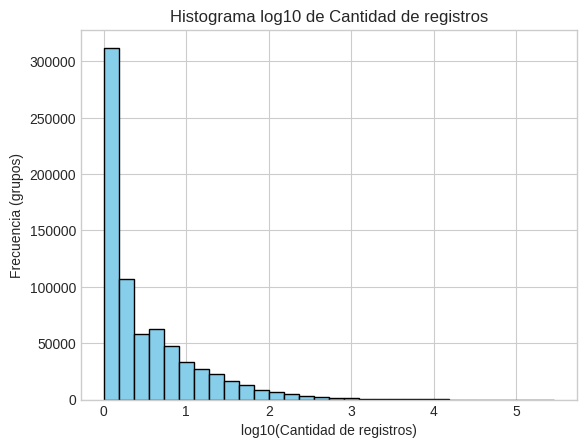

In [ ]:
x_pos = x[x > 0]
plt.hist(np.log10(x_pos), bins=30, color='skyblue', edgecolor='black')
plt.title("Histograma log10 de Cantidad de registros")
plt.xlabel("log10(Cantidad de registros)")
plt.ylabel("Frecuencia (grupos)")
plt.show()

La gran mayoría de grupos (más de 300 000) tienen pocos afiliados, entre 1 y 10 personas (log10 ≈ 0).

A medida que el tamaño del grupo crece, la frecuencia disminuye rápidamente: hay menos grupos con 100, 1000 o más afiliados.

La cola derecha larga indica que existen algunos grupos muy grandes (pocos, pero con miles o decenas de miles de afiliados).

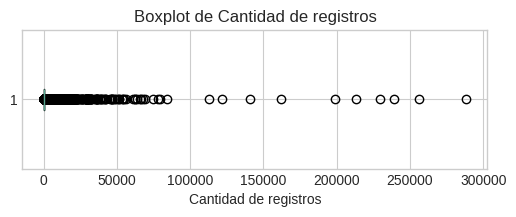

In [ ]:
    plt.figure(figsize=(6,1.8))
    plt.boxplot(x.dropna(), vert=False)
    plt.title(f"Boxplot de {col_cant_reg}")
    plt.xlabel(col_cant_reg)
    plt.show()


Frecuencias de Género


,Afiliados,%
Género,,
FEMENINO,12893374,51.18
MASCULINO,12296788,48.82


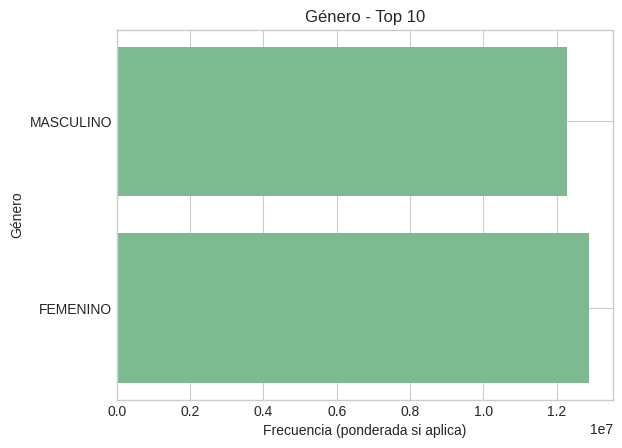


Frecuencias de Grupo etario


,Afiliados,%
Grupo etario,,
19 A 45,10846851,43.06
5 A 15,2966622,11.78
45 A 50,1704414,6.77
50 A 55,1441146,5.72
55 A 60,1422039,5.65
15 A 19,1346827,5.35
60 A 65,1330393,5.28
> 75,1228076,4.88
65 A 70,1067089,4.24


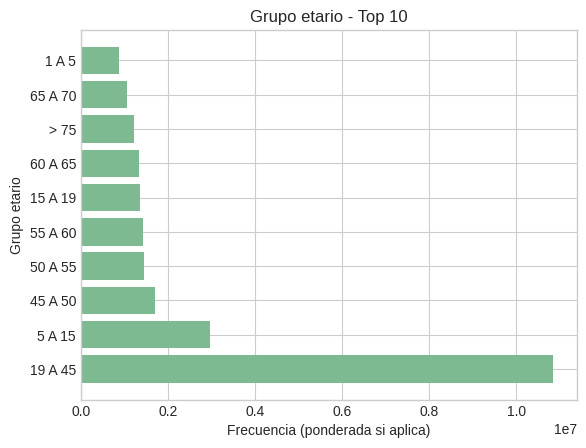


Frecuencias de Código de la entidad


,Afiliados,%
Código de la entidad,,
EPS037,4527651,17.97
EPS010,4519731,17.94
EPS005,4348818,17.26
EPS002,3592334,14.26
EPS017,1830886,7.27
EPS008,1505067,5.97
EPS018,557208,2.21
EPS041,489560,1.94
EPSS41,427926,1.70


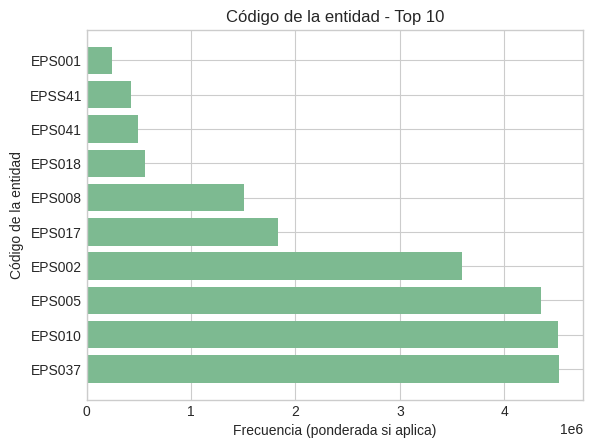


Frecuencias de Nombre de la entidad


,Afiliados,%
Nombre de la entidad,,
NUEVA EPS S.A.,4955577,19.67
EPS SURAMERICANA S.A.,4519731,17.94
ENTIDAD PROMOTORA DE SALUD SANITAS S.A.S.,4348818,17.26
SALUD TOTAL ENTIDAD PROMOTORA DE SALUD DEL REGIMEN CONTRIBUTIVO Y DEL REGIMEN SUBSIDIADO S.A.,3592334,14.26
EPS FAMISANAR S.A.S.,1830886,7.27
CAJA DE COMPENSACIÓN FAMILIAR COMPENSAR,1505067,5.97
NUEVA EPS S.A. -CM,611139,2.43
ENTIDAD PROMOTORA DE SALUD SERVICIO OCCIDENTAL DE SALUD S.A. S.O.S.,557208,2.21
ASOCIACION MUTUAL SER EMPRESA SOLIDARIA DE SALUD ENTIDAD PROMOTORA DE SALUD - MUTUAL SER EPS,297507,1.18


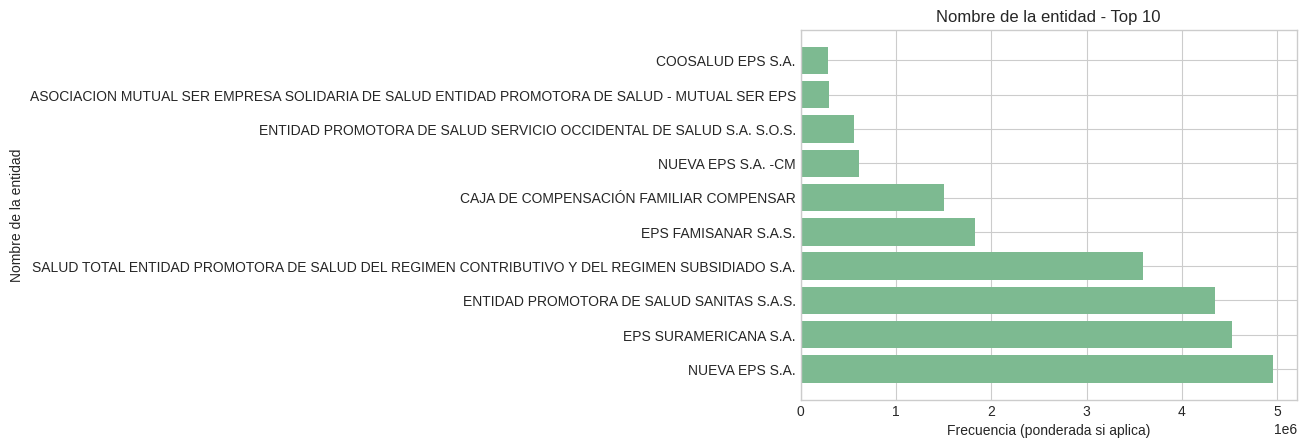


Frecuencias de Régimen


,Afiliados,%
Régimen,,
CONTRIBUTIVO,23175185,92.0
SUBSIDIADO,2014977,8.0


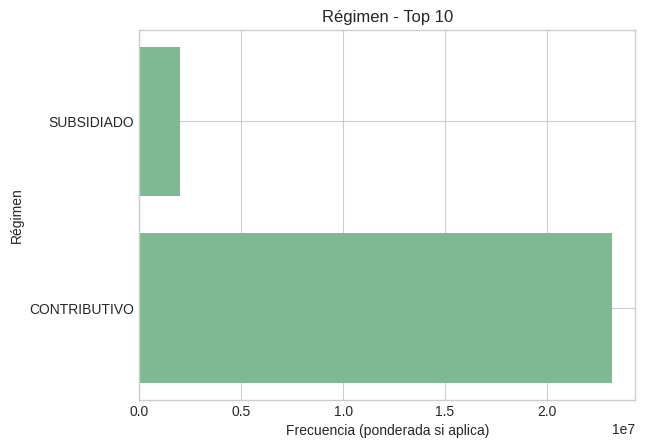


Frecuencias de Tipo de afiliado


,Afiliados,%
Tipo de afiliado,,
COTIZANTE,14367226,57.04
BENEFICIARIO,9152532,36.33
CABEZA DE FAMILIA,1604729,6.37
ADICIONAL,65675,0.26


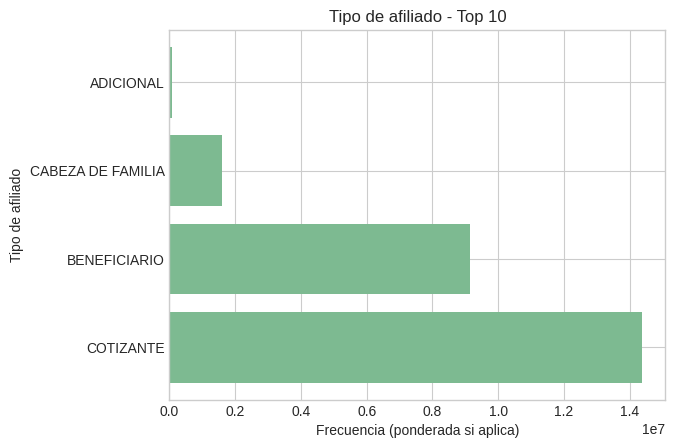


Frecuencias de Estado del afiliado


,Afiliados,%
Estado del afiliado,,
ACTIVO,24989315,99.2
PROTECCIÓN LABORAL C,200847,0.8


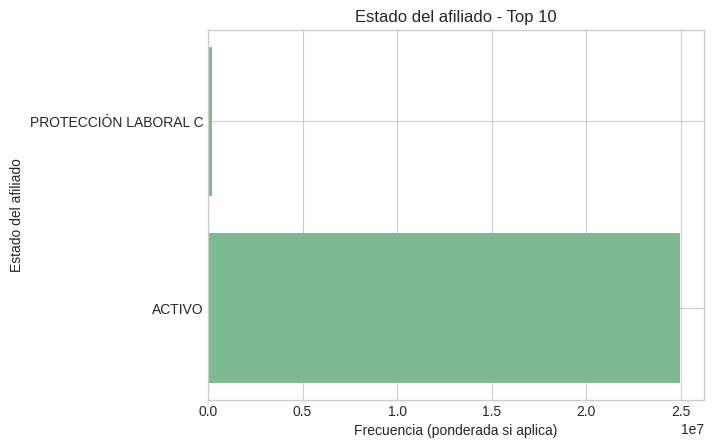


Frecuencias de Condición del beneficiario


,Afiliados,%
Condición del beneficiario,,
NO APLICA,25035088,99.38
ESTUDIANTE,95525,0.38
DISCAPACIDAD,59549,0.24


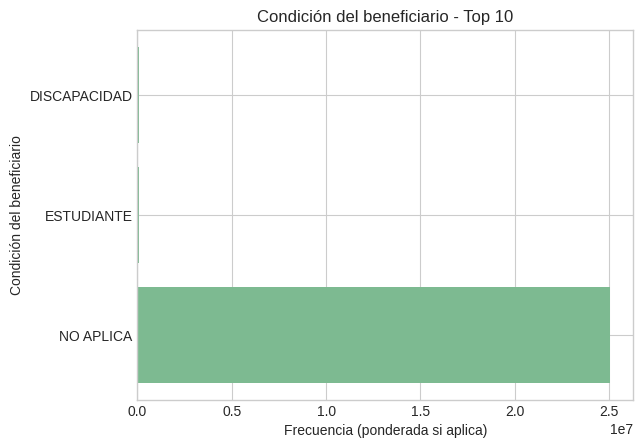


Frecuencias de Zona de Afiliación


,Afiliados,%
Zona de Afiliación,,
URBANA,21514826,85.41
URBANA-CABECERA MUNICIPAL,1733619,6.88
RURAL,1637217,6.50
RURAL - DISPERSAL,254271,1.01
URBANA - CENTRO POBLADO,31798,0.13
RURAL - RESTO RURAL,18431,0.07


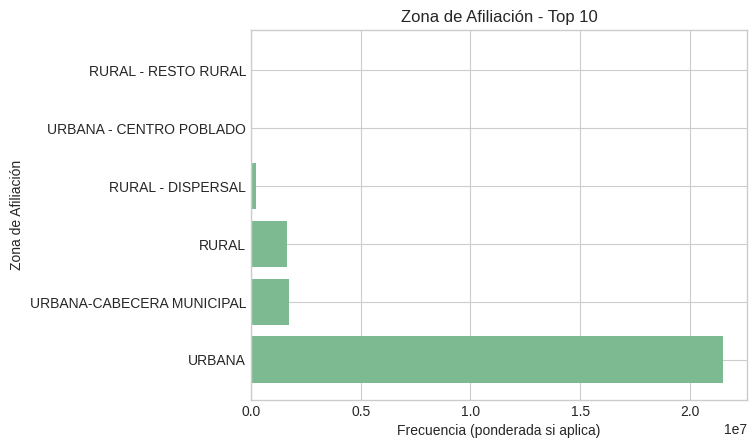


Frecuencias de Departamento


,Afiliados,%
Departamento,,
BOGOTA D.C.,6013440,23.87
ANTIOQUIA,4304149,17.09
VALLE,2612845,10.37
CUNDINAMARCA,1776918,7.05
ATLANTICO,1322776,5.25
SANTANDER,1183018,4.70
BOLIVAR,806242,3.20
RISARALDA,620187,2.46
TOLIMA,561074,2.23


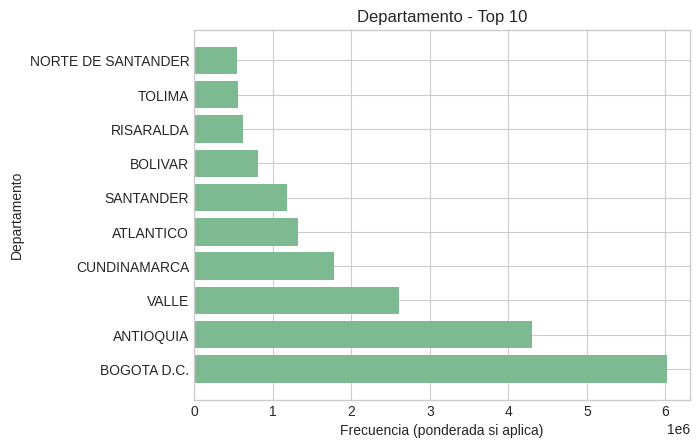


Frecuencias de Municipio


,Afiliados,%
Municipio,,
BOGOTA D.C.,6013440,23.87
MEDELLIN,2090845,8.30
SANTIAGO DE CALI,1575532,6.25
BARRANQUILLA,855879,3.40
CARTAGENA,583583,2.32
BUCARAMANGA,492521,1.96
SOACHA,404999,1.61
PEREIRA,400305,1.59
CUCUTA,367205,1.46


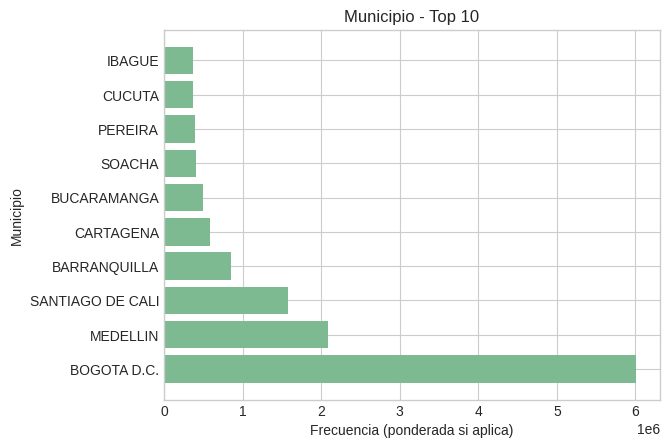


Frecuencias de Nivel del Sisbén


,Afiliados,%
Nivel del Sisbén,,
0,19816705,78.67
1,2613985,10.38
N,1438897,5.71
2,1266329,5.03
O,34388,0.14
C,10021,0.04
A,7854,0.03
3,1167,0.00
B,816,0.00


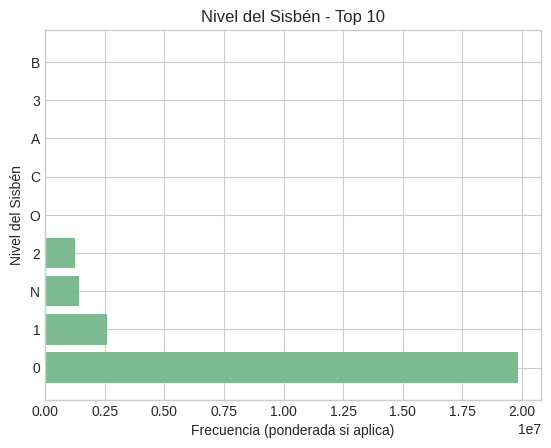


Frecuencias de Grupo poblacional del afiliado


,Afiliados,%
Grupo poblacional del afiliado,,
POBLACIÓN CON SISBEN,3876918,72.26
VÍCTIMAS DEL CONFLICTO ARMADO INTERNO,1155248,21.53
COMUNIDADES INDÍGENAS,233969,4.36
AFILIACION DE OFICIO SIN ENCUESTA SISBEN Y SIN PERTENECER A UNA POBLACIÓN ESPECIAL,34599,0.64
RECIÉN NACIDO Y MENOR DE EDAD DE PADRES NO AFILIADOS,16205,0.30
NIÑOS-NIÑAS-ADOLESCENTES Y JÓVENES EN PROCESO ADMINISTRATIVO PARA EL RESTABLECIMIENTO DE SUS DERECHOS,14642,0.27
MIGRANTE VENEZOLANO CON PE E HIJOS MENORES DE EDAD CON DOCUMENTO VÁLIDO.,6419,0.12
PERSONAS EN PRISIÓN DOMICILIARIA A CARGO DEL INPEC.,6261,0.12
HABITANTE DE LA CALLE,3754,0.07


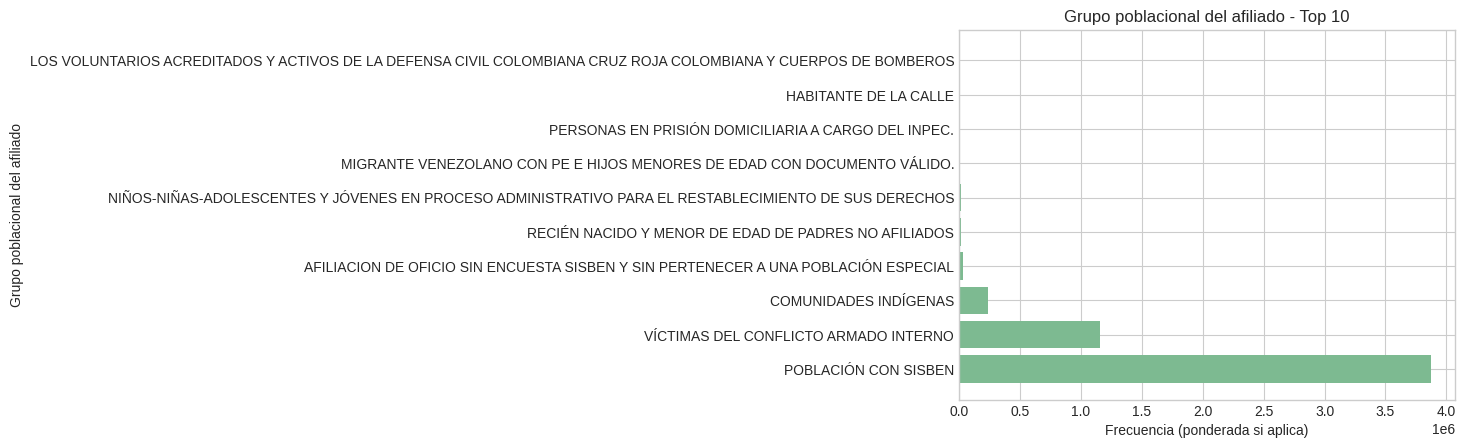

In [ ]:
# === Frecuencias de variables categóricas === #
TOP_N = 10  # cantidad de categorías que quiero ver en el gráfico

for col in cat_cols:
    print(f"\nFrecuencias de {col}")

    if col_cant_reg in df.columns:
        # Ponderar por cantidad de afiliados
        tabla = df.groupby(col)[col_cant_reg].sum().sort_values(ascending=False)
        total = tabla.sum()
        tabla = pd.DataFrame({
            "Afiliados": tabla,
            "%": round(tabla / total * 100, 2)
        })
    else:
        # Conteo simple
        tabla = df[col].value_counts(dropna=False).to_frame("Frecuencia")
        tabla["%"] = round(tabla["Frecuencia"] / len(df) * 100, 2)

    display(tabla.head(15))  # muestra las primeras filas

    # gráfico
    top = tabla.head(TOP_N)
    plt.barh(top.index.astype(str), top.iloc[:, 0])
    plt.title(f"{col} - Top {TOP_N}")
    plt.xlabel("Frecuencia (ponderada si aplica)")
    plt.ylabel(col)
    plt.show()


In [ ]:
# ============================================
# 8) Resumen ejecutivo
# ============================================
n_rows, n_cols = df.shape
resume = {
    "Filas": n_rows,
    "Columnas": n_cols,
    "Numéricas": len(num_cols),
    "Categóricas": len(cat_cols),
    "Temporales": len(date_cols),
}
print("\n=== RESUMEN EJECUTIVO ===")
display(pd.DataFrame(resume, index=["Resumen"]))

if col_cant_reg and col_regimen:
    top_reg = weighted_freq(df, col_regimen, col_cant_reg).head(3)
    print("\nTop 3 RÉGIMEN (ponderado):")
    display(top_reg)

if col_cant_reg and col_tipo_af:
    top_tipo = weighted_freq(df, col_tipo_af, col_cant_reg).head(3)
    print("\nTop 3 TIPO DE AFILIADO (ponderado):")
    display(top_tipo)

if col_cant_reg and col_zona:
    top_zona = weighted_freq(df, col_zona, col_cant_reg).head(3)
    print("\nTop 3 ZONA (ponderado):")
    display(top_zona)

if col_cant_reg and col_depto:
    top_dep = weighted_freq(df, col_depto, col_cant_reg).head(3)
    print("\nTop 3 DEPARTAMENTO (ponderado):")
    display(top_dep)


=== RESUMEN EJECUTIVO ===


,Filas,Columnas,Numéricas,Categóricas,Temporales
Resumen,730711,17,1,13,1



Top 3 RÉGIMEN (ponderado):


,Frecuencia_ponderada,%
Régimen,,
CONTRIBUTIVO,23175185,92.0
SUBSIDIADO,2014977,8.0



Top 3 TIPO DE AFILIADO (ponderado):


,Frecuencia_ponderada,%
Tipo de afiliado,,
COTIZANTE,14367226,57.04
BENEFICIARIO,9152532,36.33
CABEZA DE FAMILIA,1604729,6.37



Top 3 ZONA (ponderado):


,Frecuencia_ponderada,%
Zona de Afiliación,,
URBANA,21514826,85.41
URBANA-CABECERA MUNICIPAL,1733619,6.88
RURAL,1637217,6.50



Top 3 DEPARTAMENTO (ponderado):


,Frecuencia_ponderada,%
Departamento,,
BOGOTA D.C.,6013440,23.87
ANTIOQUIA,4304149,17.09
VALLE,2612845,10.37
